# BlochSphereV0

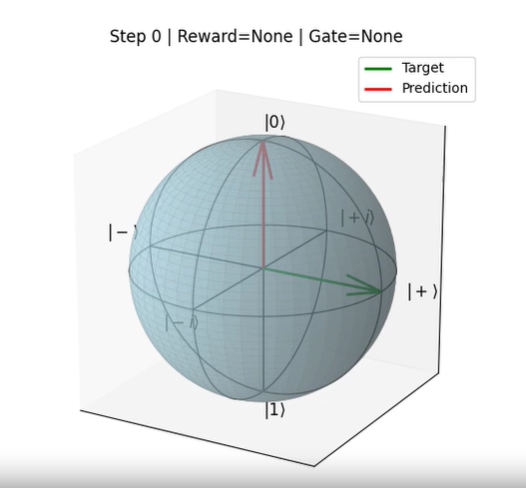

## Description

`BlochSphereV0` is a single-qubit quantum environment intended for teaching, visualization, and 
simple RL-style control experiments. It is based on the `QuantumEnv` base class. The environment represents the qubit state on the Bloch sphere and 
provides a discrete set of quantum gates (Clifford + common rotations) as actions. 

The agent's goal is to steer the qubit from the fixed initial state `|0\rangle` to a specified target 
state (by default `|+\rangle`) within a minimum number of steps.

As seen in the **Render** (see `results\core`): a semi-transparent Bloch sphere with labeled poles and 
equatorial points. The green arrow shows the target Bloch vector while the red arrow shows the evolving 
state (prediction) across steps. The sphere shows solid X, Y, Z axes and circular outlines for the XY, 
XZ, and YZ planes for visual reference.



## Action Space

The action space is discrete. 

Each action applies a unitary gate to the current single-qubit state (left-multiplication by its 2x2 
unitary matrix). Actions are deterministic and map directly to a fixed gate or rotation.

| Num | Action     | Description              |
| --- | ---------- | ------------------------ |
| 0   | `H`        | Hadamard gate            |
| 1   | `X`        | Pauli-X (NOT)            |
| 2   | `Y`        | Pauli-Y                  |
| 3   | `Z`        | Pauli-Z                  |
| 4   | `S`        | Phase gate (S)           |
| 5   | `SDG`      | S† (S dagger)            |
| 6   | `T`        | T gate                   |
| 7   | `TDG`      | T† (T dagger)            |
| 8   | `RX_pi_2`  | Rotation about X by +π/2 |
| 9   | `RX_pi_4`  | Rotation about X by +π/4 |
| 10  | `RX_-pi_4` | Rotation about X by -π/4 |
| 11  | `RY_pi_2`  | Rotation about Y by +π/2 |
| 12  | `RY_pi_4`  | Rotation about Y by +π/4 |
| 13  | `RY_-pi_4` | Rotation about Y by -π/4 |
| 14  | `RZ_pi_2`  | Rotation about Z by +π/2 |
| 15  | `RZ_pi_4`  | Rotation about Z by +π/4 |
| 16  | `RZ_-pi_4` | Rotation about Z by -π/4 |

The `action_space` is a `gymnasium.spaces.Discrete(len(actions))` where the integer index selects the action above.



## Observation Space

The observation is a 3-dimensional `ndarray` corresponding to the Bloch vector `(x, y, z)` of the current pure qubit state. 
Shape: `(3,)`, dtype `float32`, with each component bounded in `[-1, 1]`.

| Num | Observation component | Min | Max | Meaning                                 |
| --- | --------------------- | --: | --: | --------------------------------------- |
| 0   | `x`                   |  -1 |   1 | 2 Re(ρ₀₁) — X component of Bloch vector |
| 1   | `y`                   |  -1 |   1 | 2 Im(ρ₁₀) — Y component of Bloch vector |
| 2   | `z`                   |  -1 |   1 | ρ₀₀ - ρ₁₁ — Z component of Bloch vector |

Notes:

* Internally the environment stores the statevector `|ψ⟩` (complex two-component vector) and converts to the Bloch vector for observations using the density matrix `ρ = |ψ⟩⟨ψ|`.



## Rewards

Reward is defined as the quantum state fidelity (squared overlap) between the current state and the target state:

```
reward = |⟨target | state⟩|^2
```

This produces a continuous reward in `[0, 1]`. 

Typical usage in episodic RL: treat higher reward as progress; the environment flags `done` when reward 
exceeds `reward_tolerance` (default `0.99`). The environment does not subtract step penalties by default,
but users can wrap or modify rewards to encourage shorter trajectories.



## Starting State

On `reset()` the environment:

* sets `steps = 0`;
* initializes the qubit to `|0⟩` (statevector `[1, 0]`);
* sets `history` to contain the initial Bloch vector and metadata `('None','None')`.

By default the target state is `|+⟩ = (|0⟩ + |1⟩)/√2` (unless a different `target_state` is passed to the constructor). The code example in this class shows the `target_state` argument available in `__init__` so users can choose a different target on env construction.



## Episode End

An episode terminates (i.e., `done=True`) when either:

1. **Success / Termination**: The fidelity `|⟨target|state⟩|^2` is strictly greater than `reward_tolerance` (default `0.99`).
2. **Truncation**: The number of steps reaches `max_steps` (default `20`).

The `step()` method returns `(observation, reward, done, info)` matching `gymnasium.Env` conventions. `info` is currently empty but `history` is stored on the environment instance for inspection and rendering.



## Render

`render(save_path=None, interval=800)` produces a Matplotlib 3D animation visualizing the Bloch sphere, target vector (green), and the recorded state trajectory (red vector updated per frame). 
If `save_path` is provided, the animation is saved (FFmpeg writer is used); otherwise the animation is shown with `plt.show()`.

Rendering details:

* Sphere is drawn once as a translucent mesh.
* X/Y/Z axes are drawn as solid lines and equatorial/circular outlines for XY/XZ/YZ planes are shown.
* Labels placed for canonical states: `|0⟩`, `|1⟩`, `|+⟩`, `|−⟩`, `|+i⟩`, `|-i⟩`.
* The animation title displays `Step`, `Reward` (rounded), and `Gate` applied at that step.



## Arguments (Constructor & Reset Options)

Constructor signature (as implemented):

```python
BlochSphereV0(target_state, max_steps=20, reward_tolerance=0.99)
```

* `target_state`: complex 2-vector specifying the target pure state. If `None`, defaults to `|+⟩`.
* `max_steps`: maximum number of actions per episode (truncation threshold).
* `reward_tolerance`: fidelity threshold above which the episode is marked successful.
* `ffmpeg`: if `True`, uses FFmpeg for saving animations; otherwise uses Pillow (GIF).


`reset()` currently ignores an `options` dict for seeding or custom initialization; this can be extended to allow randomized initial states or alternative targets.


Initial Observation (r, theta, phi): [0. 0. 1.]
After 0 action -> Observation: [1. 0. 0.]
Reward: 0.9999999999999996 Done: True


d:\Quantum-Reinforcement-Learning\qrl_env\lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


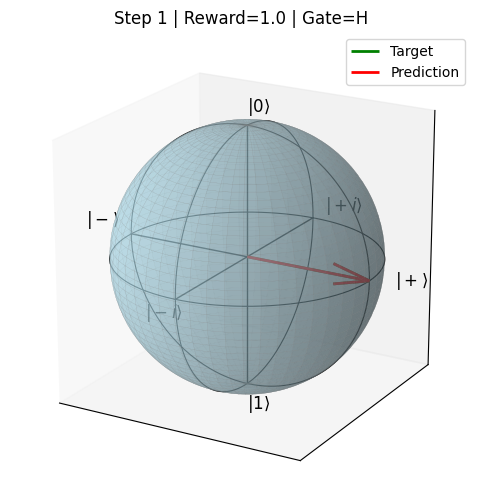

In [ ]:
### Example -> Stand alone implementation

import numpy as np
from qrl.env import BlochSphereV0

# Target vector is |+> = (|0> + |1>)/sqrt(2)
target_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

# Initialize environment
# set ffmpeg=True if you have ffmpeg installed to save as mp4, or ffmpeg=False to save as gif
env = BlochSphereV0(target_state=target_state, max_steps=20, reward_tolerance=0.99, ffmpeg=False)

# Reset
obs, _ = env.reset()
print("Initial Observation (r, theta, phi):", obs)

# Randomly sample actions
for _ in range(env.max_steps):
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    print(f"After {action} action -> Observation:", obs)
    print("Reward:", reward, "Done:", done)

    if done:
        break

# Render Bloch sphere
env.render(save_path_without_extension="bloch_sphere")

In [ ]:
from pennylane import numpy as np
import pennylane as qml
from qrl.env import ProbabilityV0

n_qubits = 2
target_distribution = np.array([0.25, 0.25, 0.25, 0.25])  # Example target distribution

# initialize environment
# set ffmpeg=True if you have ffmpeg installed to save as mp4, or ffmpeg=False to save as gif
env = ProbabilityV0(
    n_qubits=n_qubits,
    target_distribution=target_distribution,
    alpha=0.7,   # KL vs L2 weight
    beta=0.01,   # step penalty
    max_steps=10,
    ffmpeg=False
)

# Reset environment
params, _ = env.reset()


# Use PennyLane's optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.2)

# params = env.params.copy()
for step in range(env.max_steps):
    params, cost_val = opt.step_and_cost(env.cost_fn, params)
    probs = env.circuit(params)

    # Save history for rendering
    env.history.append(probs)
    env.params = params  # update env params
    reward = -cost_val
    env.rewards.append(-cost_val)
    print(f"Step {step}: Reward = {reward:.4f}")

    if reward > -1e-2:  # close to perfect
        break

# Animate the full evolution
env.render(save_path_without_extension="probability_v0")

## Implementation Notes & Extensions

* The environment expects unitary matrices to be available via a `GATES` dict for named Clifford gates and helper functions `RX(theta)`, `RY(theta)`, `RZ(theta)` for parameterized rotations. Those helpers should return 2×2 NumPy/Pennylane-arrays that multiply the statevector.
* Currently the state is pure and represented as a statevector. To support mixed states or noise channels, one could change internal storage to density matrices and adapt `_state_to_bloch` accordingly.
* Reward shaping: to encourage shorter trajectories, add a step penalty (e.g., `-0.01`) or give a sparse success reward on reaching the target.
* Observation augmentation: include the current step number, recent gate applied, or the fidelity as extra observation channels if training agents that benefit from that information.



## Version History

* **v0**: Initial design and implementation. Single-qubit pure-state environment with fixed initial state `|0⟩`, discrete gate set, fidelity reward, Matplotlib-based Bloch sphere renderer, and history tracking.

## References (Suggested Reading)

* Bloch sphere — standard geometric representation for a qubit.
* Nielsen, M. A., & Chuang, I. L., *Quantum Computation and Quantum Information* (for unitary gate definitions and single-qubit geometry).
